## HW 4
Botasheva Zhanna

## Когда-нибудь это закончится? Симуляция распространения болезни. Работа с NetworkX.

In [10]:
# Импорт основных библиотек
import numpy as np
import pandas as pd
import math

# Импорт библиотеки для работы с сетевыми структурами
import networkx as nx

# Импорт библиотеки построения диаграмм и графиков
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

from datetime import datetime, timedelta
from tqdm import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)

In [9]:
# Загрузка исходных данных об аэропортах
flights = pd.read_csv('2008.csv')

# Вывод датасета
flights.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4   2003.0        1955   2211.0   
1  2008      1           3          4    754.0         735   1002.0   
2  2008      1           3          4    628.0         620    804.0   
3  2008      1           3          4    926.0         930   1054.0   
4  2008      1           3          4   1829.0        1755   1959.0   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        2225            WN        335  ...    4.0      8.0          0   
1        1000            WN       3231  ...    5.0     10.0          0   
2         750            WN        448  ...    3.0     17.0          0   
3        1100            WN       1746  ...    3.0      7.0          0   
4        1925            WN       3920  ...    3.0     10.0          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0           NaN          NaN      NaN   
1               NaN         0           NaN          NaN      NaN   
2               NaN         0           NaN          NaN      NaN   
3               NaN         0           NaN          NaN      NaN   
4               NaN         0           2.0          0.0      0.0   

   SecurityDelay  LateAircraftDelay  
0            NaN                NaN  
1            NaN                NaN  
2            NaN                NaN  
3            NaN                NaN  
4            0.0               32.0  

[5 rows x 29 columns]

In [11]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

Оставим столбцы:

* Year - год
* Month - месяц
* DayofMonth - день месяца
* CRSDepTime - запланированное время отправления (местное)
* CRSArrTime - запланированное время прибытия (местное)
* Origin - код аэропорта IATA отправления
* Dest - код аэропорта IATA назначения

Поскольку время указано в местном часовом поясе, мы извлекем часовые пояса отсюда и будем использовать их при преобразовании в utc datetime.
DayOfMonth - это день вылета рейса, поэтомунужно контролировать ночные рейсы.

In [13]:
# Получение информации о часовых поясах аэропортов
airport_tz = pd.read_fwf('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', names=['code', 'tz'], colspecs=[(0, 3), (3, None)])

# Проверим присутствуют ли все аэропорты
airports = pd.Series(flights['Origin'].unique())
codes = airport_tz.code.unique()
bad = [ap not in codes for ap in airports]
for a in airports[bad]:
    print(a)

PFN


PFN - закрытый аэропорт в Панама-Сити, штат Флорида. У него часовой пояс Америка/Чикаго. Добавим в датасет:

In [14]:
# Часовой пояс
airport_tz.loc[len(airport_tz.index)] = ['PFN', 'America/Chicago']
# Код
airport_tz = airport_tz.set_index('code')

airport_tz.tail(4)

tz
code                  
ZZO      Asia/Sakhalin
ZZU    Africa/Blantyre
ZZV   America/New_York
PFN    America/Chicago

In [15]:
flights[['CRSDepTime', 'CRSArrTime']].describe()

CRSDepTime    CRSArrTime
count  7.009728e+06  7.009728e+06
mean   1.326086e+03  1.494801e+03
std    4.642509e+02  4.826728e+02
min    0.000000e+00  0.000000e+00
25%    9.250000e+02  1.115000e+03
50%    1.320000e+03  1.517000e+03
75%    1.715000e+03  1.907000e+03
max    2.359000e+03  2.400000e+03

 CRSArrTime равно 2400, что предположительно равно 00:00 следующего дня, изменим его на 23:59 дня.

In [16]:
def to_time(int_var):
    """
   Возвращает время, записанное как целое число, и форматирует его как time (24 часа) в строковом формате.
   Примеры:
    1 -> 00:01
    41 -> 00:41
    537 -> 05:37
    1714 -> 17:14
    """
    str_var = str(int_var).rjust(4, '0')
    return str_var[:2] + ':' + str_var[2:]

@np.vectorize
def get_tz(code):
    """
    Возвращает часовой пояс в виде файла dateutil.tz.tz.tzfile из кода аэропорта
    """
    tz = dateutil.tz.gettz(airport_tz.loc[code, 'tz'])
    return tz

@np.vectorize
def to_datetime(year, month, day, time, tz):
    """
    Возвращает время передачи данных в UTC
    """
    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m), tzinfo=tz).astimezone(pytz.utc)#.replace(tzinfo=None)
    return result
    #возвращает np.datetime64(result)

def preprocess(df):
    
    # Заменим 24:00 на 23:53
    df.loc[df['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    df.loc[df['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359
    
    # создадим столбец со временем отправления и прибытия в виде строки
    df['arr_time'] = df['CRSArrTime'].apply(to_time)
    df['dep_time'] = df['CRSDepTime'].apply(to_time)
    
    # создадим столбцы даты и времени
    df['arr_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['arr_time'], get_tz(df['Dest']))
    df['dep_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['dep_time'], get_tz(df['Origin']))
    
    # оставим только соответствующие столбцы 
    result = df[['dep_datetime', 'Origin', 'arr_datetime', 'Dest']]

    # переименуем столбцы
    result.columns = ['departure', 'origin', 'arrival', 'dst']
    
    # контроль ночных рейсов 
    result.loc[result['departure'] > result['arrival'], 'arrival'] += timedelta(hours=24)

    # сортировка по времени вылета
    result.sort_values('departure', inplace=True)
    
    return result

In [18]:
import os

selected_month = 7
dataset_path = 'dataset.csv'
if os.path.exists(dataset_path):
    flights_1m = pd.read_csv(dataset_path)
else:
    flights_1m = flights[flights.Month == selected_month]
    flights_1m.to_csv('dataset.csv', index=False)
flights_1m.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
3604175  2008      7           2          3    906.0         910   1027.0   
3604176  2008      7           2          3    834.0         835    953.0   
3604177  2008      7           2          3   1610.0        1555   1733.0   
3604178  2008      7           2          3    728.0         730    848.0   
3604179  2008      7           2          3   2047.0        2045   2201.0   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
3604175        1035            WN       1835  ...    5.0     10.0          0   
3604176        1005            WN       1941  ...    5.0     10.0          0   
3604177        1720            WN       2292  ...    3.0     10.0          0   
3604178         855            WN       2317  ...    5.0     10.0          0   
3604179        2210            WN       2423  ...    4.0      8.0          0   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
3604175               NaN         0           NaN          NaN      NaN   
3604176               NaN         0           NaN          NaN      NaN   
3604177               NaN         0           NaN          NaN      NaN   
3604178               NaN         0           NaN          NaN      NaN   
3604179               NaN         0           NaN          NaN      NaN   

         SecurityDelay  LateAircraftDelay  
3604175            NaN                NaN  
3604176            NaN                NaN  
3604177            NaN                NaN  
3604178            NaN                NaN  
3604179            NaN                NaN  

[5 rows x 29 columns]

In [21]:
import dateutil
import pytz

prepared_path = 'prepared.pkl'
if os.path.exists(prepared_path):
    df = pd.read_pickle(prepared_path)
else:
    df = preprocess(flights_1m).reset_index(drop=True)
    df.to_pickle(prepared_path)
df.head()

C:\Users\Zhanna Botasheva\AppData\Local\Temp\ipykernel_27256\3003103974.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arr_time'] = df['CRSArrTime'].apply(to_time)
C:\Users\Zhanna Botasheva\AppData\Local\Temp\ipykernel_27256\3003103974.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dep_time'] = df['CRSDepTime'].apply(to_time)
C:\Users\Zhanna Botasheva\AppData\Local\Temp\ipykernel_27256\3003103974.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

departure origin                   arrival  dst
0 2008-07-01 04:40:00+00:00    MCO 2008-07-01 07:26:00+00:00  SJU
1 2008-07-01 05:55:00+00:00    SJU 2008-07-01 09:43:00+00:00  JFK
2 2008-07-01 06:01:00+00:00    SLC 2008-07-01 10:29:00+00:00  JFK
3 2008-07-01 06:25:00+00:00    DEN 2008-07-01 10:07:00+00:00  PHL
4 2008-07-01 06:30:00+00:00    SLC 2008-07-01 10:17:00+00:00  ATL

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627931 entries, 0 to 627930
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   departure  627931 non-null  datetime64[ns, UTC]
 1   origin     627931 non-null  object             
 2   arrival    627931 non-null  datetime64[ns, UTC]
 3   dst        627931 non-null  object             
dtypes: datetime64[ns, UTC](2), object(2)
memory usage: 19.2+ MB


## Часть 1. Симуляция заражения

In [23]:
initial_dt = to_datetime([2008], [6], [1], ['00:00'], [pytz.utc])[0]
def do_simulation(airport, p, debug=False):
    """
     Запустим имитацию распространения инфекции
     :параметр airport: str
     код аэропорта первоначально зараженного аэропорта
     :параметр p: плавающая
     вероятность заражения нового аэропорта
     :параметр debug: bool, по умолчанию False
     Если True, выведите отладочную информацию
     :return: dict
     словарь распространения инфекции. дата и время в качестве ключа и код аэропорта в качестве данных.
    """
    infected = [airport]
    results = {airport: initial_dt}

    for row in df.itertuples():
        chance = np.random.uniform()
        # origin infected, dst is not infected yet and checking probability of infection
        if (row.origin in infected) and (row.dst not in infected) and (chance <= p):
            # control for flights which should not be infected yet 
            #(infection flight arrival is in future in comparison to departure flights to other airports)
            if results[row.origin] > row.departure:
                if debug:
                    print('too early!', row)
                continue
            if debug:
                print('Infected!!', row)
            infected.append(row.dst)
            results[row.dst] = row.arrival
        else:
            continue
    return results

In [26]:
# Кол-во зараженных аэропортов
N = len(df['origin'].unique())
p = 0.01
airport = 'ABE'
print('Starting airport:', airport)
np.random.seed(7)
res = do_simulation(airport, p)
print(f'Infected in a month: {len(res)}/{N}')

Starting airport: ABE
Infected in a month: 218/293


## Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?

In [28]:
def run_simulations(airport, probs, n, debug=False):
    results = pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
    for p in probs:
        print('simulations for p =', p)
        for i in tqdm(range(n)):
            # run simulation
            sim_res = pd.DataFrame.from_dict(do_simulation(airport, p), orient='index').reset_index()
            sim_res.columns = ['airport', 'infected']
            sim_res['sim_id'] = i
            sim_res['p'] = p
            results = pd.concat([results, sim_res]) 
    return results

In [29]:
# Список вероятностей 
probs = [0.01, 0.05, 0.1, 0.5, 1]
# Число симуляций
n_sim = 10
# fix seed
np.random.seed(7)
print('Starting airport:', airport)
# Результаты
results_df = run_simulations(airport, probs, n_sim)#pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
results_df.to_pickle('results.pkl')

Starting airport: ABE
simulations for p = 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.40s/it]


simulations for p = 0.05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.92s/it]


simulations for p = 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.96s/it]


simulations for p = 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.06s/it]


simulations for p = 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]


In [30]:
# Временные границы
min_time = df['departure'].min()
max_time = df['arrival'].max()
print(f'From {min_time} to {max_time}')

# Словарь для записи результатов
tsim_res = dict()

# Временная дельта
dt = timedelta(hours=12)

# Временная точка
tp = min_time
while tp < max_time:
    infected_pct = results_df[results_df.infected <= tp].groupby(['p', 'sim_id']).size()/N
    infected_pct = infected_pct.reset_index().groupby('p')[0].mean()
    tsim_res[tp] = infected_pct
    tp += dt

From 2008-07-01 04:40:00+00:00 to 2008-08-01 15:30:00+00:00


C:\Users\Zhanna Botasheva\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


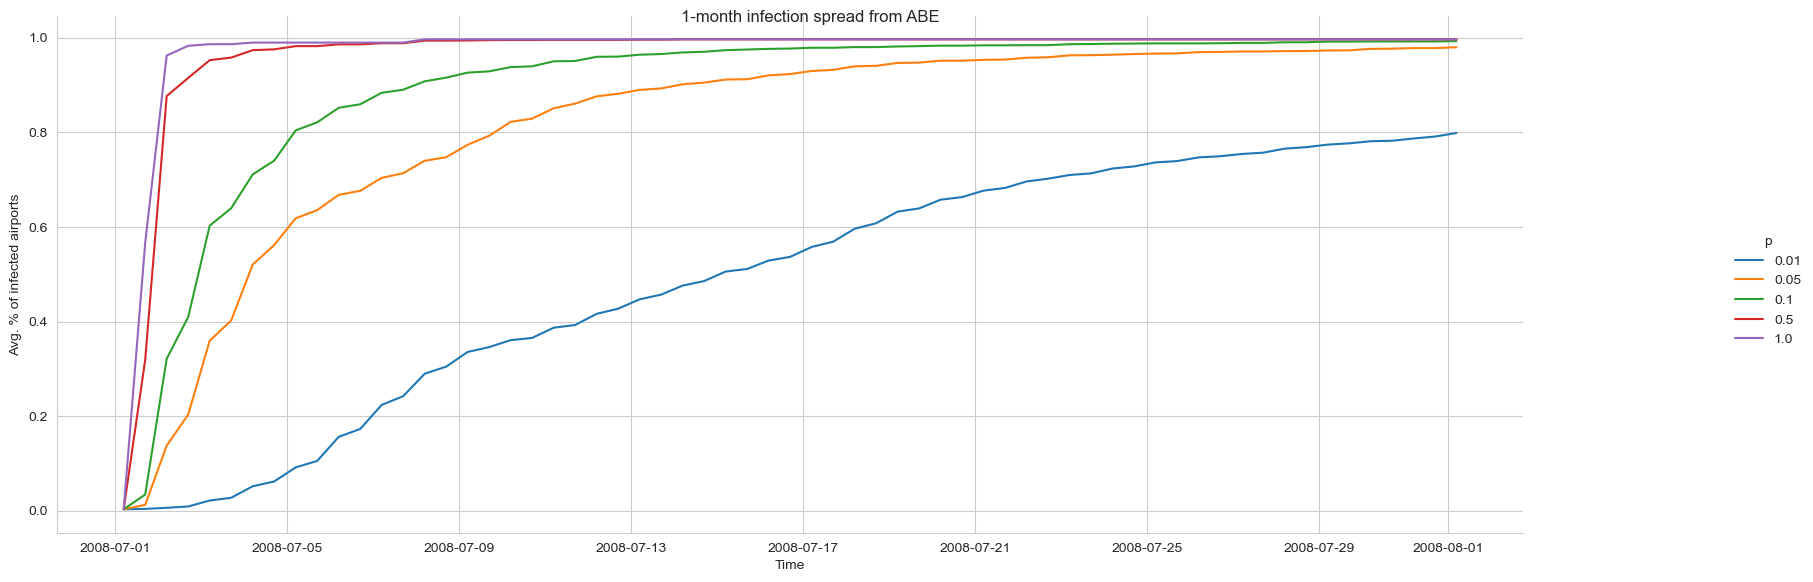

In [31]:
# Создание датасета для визуализации
data_viz = pd.DataFrame.from_dict(tsim_res, orient='index')
data_viz = data_viz.reset_index().melt(id_vars='index', var_name='p')
data_viz['p'] = data_viz.p.astype('category')
# Визуализация
sns.set_style('whitegrid')
lp = sns.relplot(data=data_viz, kind='line', x='index', y='value', hue='p')
lp.fig.set_figwidth(20)
lp.fig.set_figheight(6)
lp.fig.suptitle(f'1-month infection spread from {airport}')
lp.ax.set_xlabel('Time')
lp.ax.set_ylabel('Avg. % of infected airports')
plt.show()

## Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

* Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
* Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
* Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
* Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

In [32]:
@np.vectorize
def combine_orig_dst(origin, dst):
    """
    Combine airport codes in aphabetical order
    """
    if origin < dst:
        result = f'{origin} {dst}'
    else:
        result = f'{dst} {origin}'
    return result

In [34]:
# Кол-во рейсов
NF = df.shape[0]

# Создадим список ребер
df['edge'] = combine_orig_dst(df.origin, df.dst)
edgelist = df.groupby('edge').size()/NF
edgelist = edgelist.reset_index()
edgelist[['node1', 'node2']] = edgelist['edge'].str.split(' ', expand=True)
edgelist = edgelist[['node1', 'node2', 0]]
edgelist.columns = ['node1', 'node2', 'weight']
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

node1 node2    weight
0      ABE   ATL  0.000191
1      ABE   CLE  0.000169
2      ABE   CLT  0.000096
3      ABE   CVG  0.000086
4      ABE   DTW  0.000290
...    ...   ...       ...
2293   SNA   STL  0.000099
2294   STL   TPA  0.000291
2295   STL   TUL  0.000277
2296   SWF   TPA  0.000099
2297   TLH   TPA  0.000252

[2298 rows x 3 columns]

In [35]:
# Создадим граф
ag = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(ag.number_of_nodes(), 'nodes and ', ag.number_of_edges(), 'edges in the graph')

293 nodes and  2298 edges in the graph


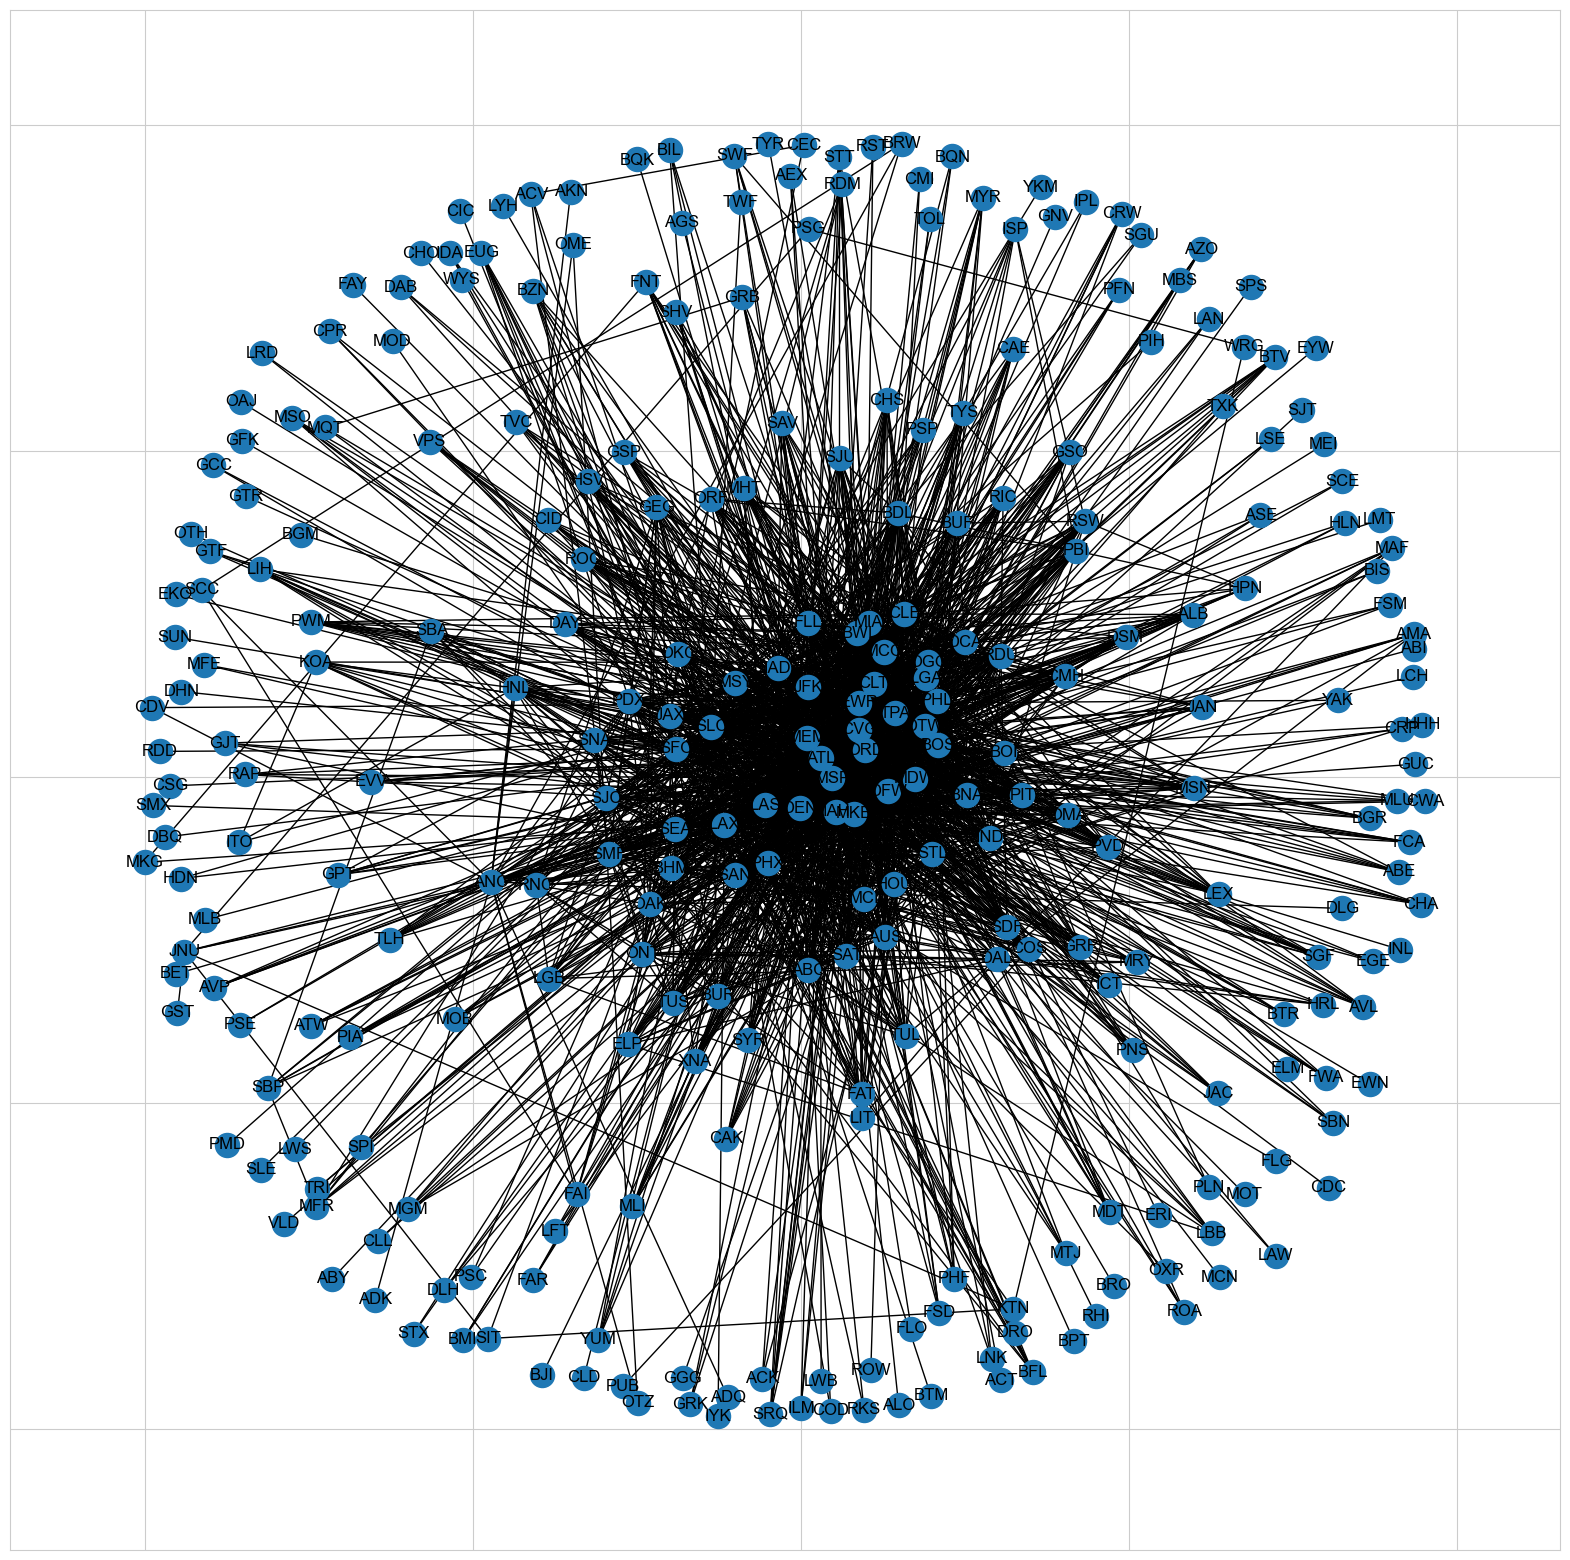

In [36]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(ag)

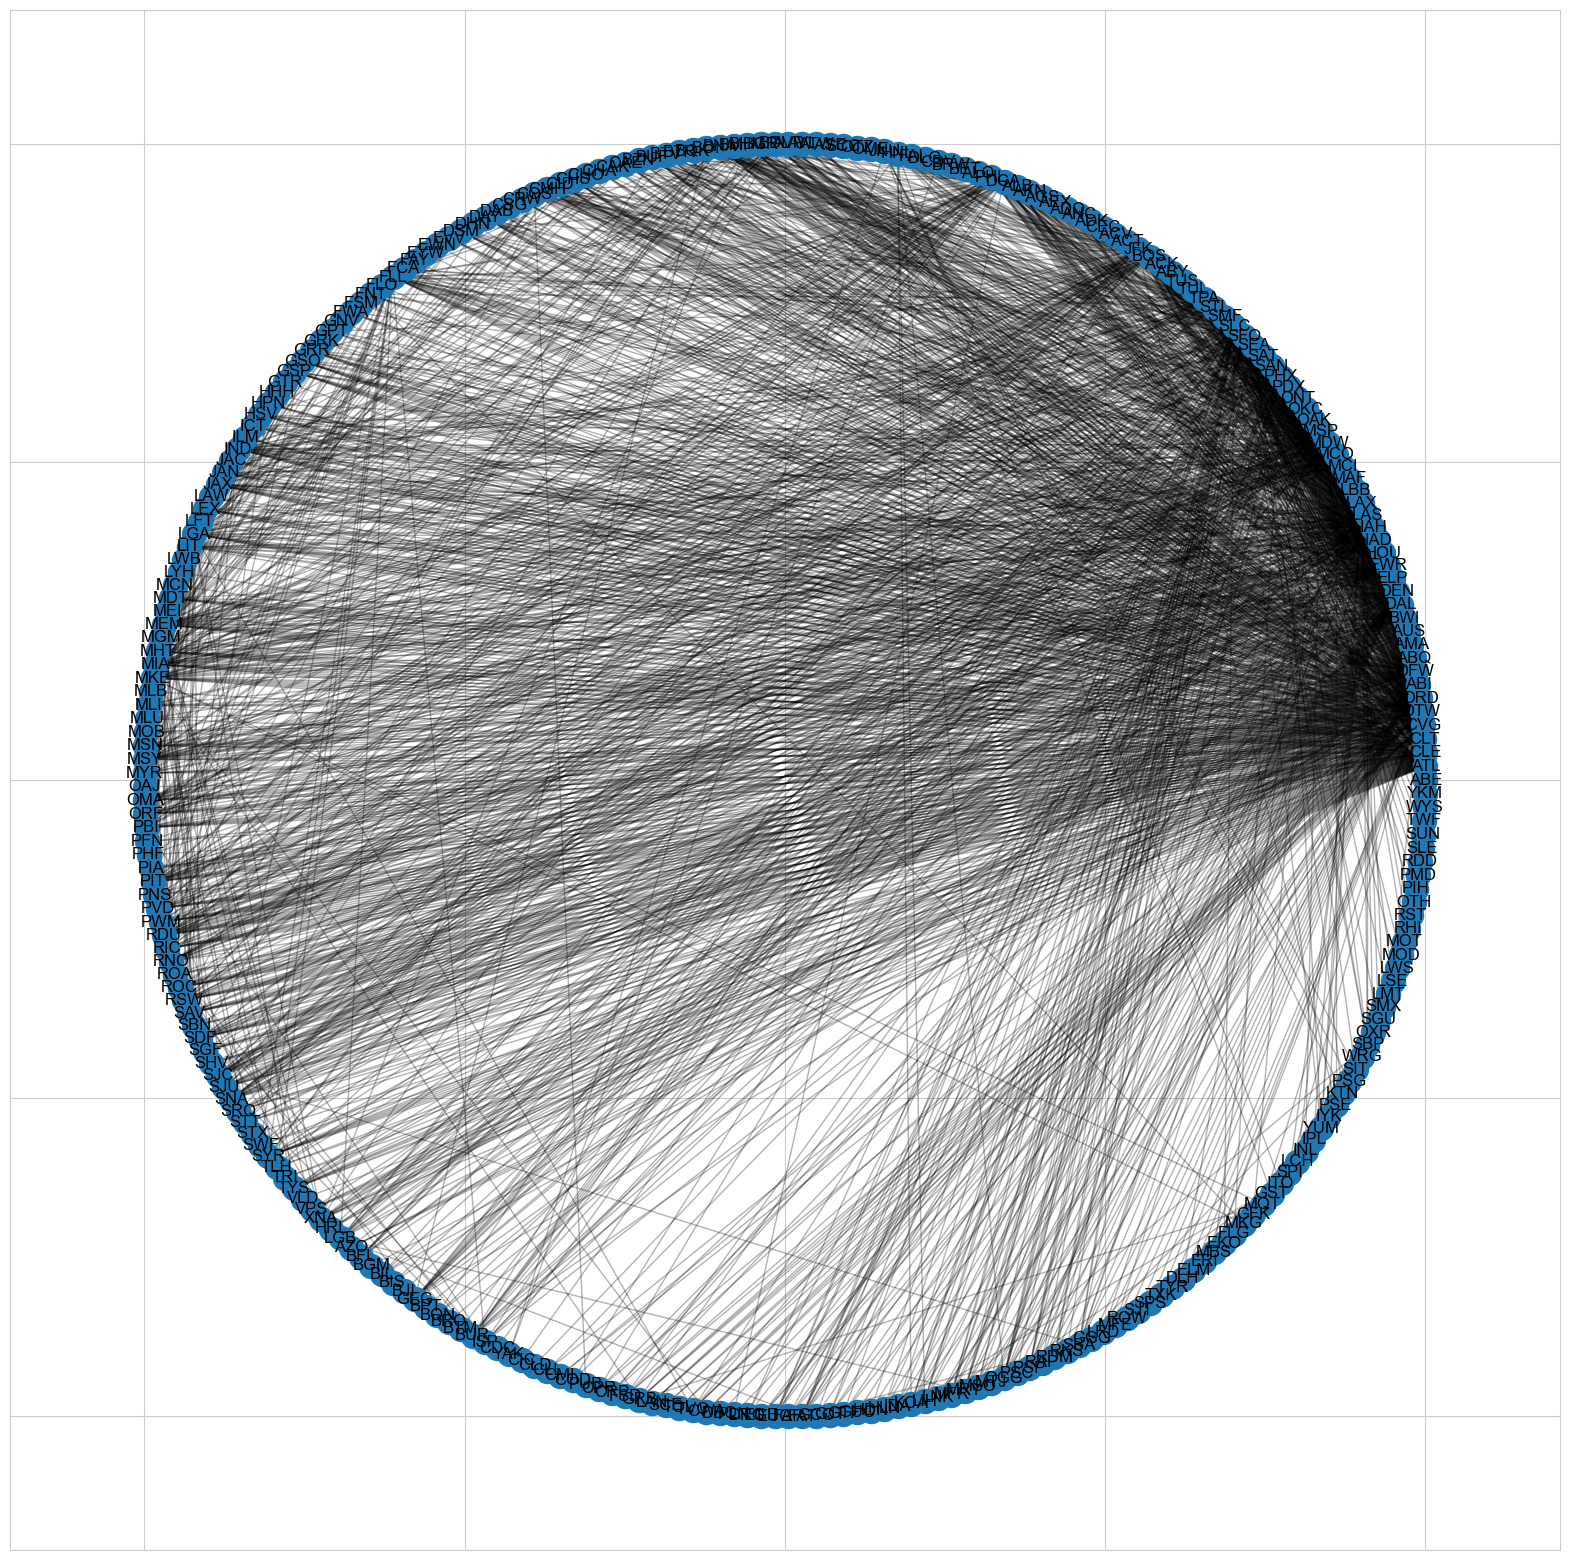

In [37]:
fig = plt.figure(1, figsize=(20, 20))
pos=nx.circular_layout(ag)
nx.draw_networkx_nodes(ag,pos=pos)
nx.draw_networkx_edges(ag,pos=pos,alpha=0.3)
nx.draw_networkx_labels(ag, pos=pos)
plt.show()

In [38]:
clustering = nx.clustering(ag, weight='weight')
degree = dict(ag.degree(weight='weight'))
centrality = nx.betweenness_centrality(ag, weight='weight')

In [40]:
# Объединим метрики в DataFrame
node_metrics = pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
    pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
    pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics.head()

clustering    degree  centrality
ABE    0.078986  0.001201    0.000000
ATL    0.024927  0.116040    0.172814
CLE    0.040309  0.019860    0.093858
CLT    0.055862  0.034459    0.020033
CVG    0.025193  0.025802    0.133052

In [41]:
node_metrics.sort_values('clustering', ascending=False)

clustering    degree  centrality
MFE    0.190935  0.001158    0.000000
RST    0.170673  0.000850    0.000000
LAW    0.169001  0.000850    0.000000
FAR    0.166427  0.001191    0.000000
PSC    0.165727  0.000729    0.000000
..          ...       ...         ...
BET    0.000000  0.000280    0.000000
CDV    0.000000  0.000197    0.024479
DLG    0.000000  0.000099    0.000000
PUB    0.000000  0.000003    0.000000
YKM    0.000000  0.000172    0.000000

[293 rows x 3 columns]

In [42]:
node_metrics.describe()

clustering      degree  centrality
count  293.000000  293.000000  293.000000
mean     0.061612    0.006826    0.013992
std      0.046922    0.014570    0.038103
min      0.000000    0.000003    0.000000
25%      0.000000    0.000393    0.000000
50%      0.066123    0.001416    0.000000
75%      0.093893    0.005037    0.006326
max      0.190935    0.116040    0.234105

In [43]:
np.random.seed(77)
results_50 = run_simulations('ABE', [0.5], 50)
results_50.to_pickle('sim50res.pkl')

simulations for p = 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:01<00:00,  7.24s/it]


In [44]:
results_50 = results_50.reset_index(drop=True)
# Время начала
st = results_50.loc[0, 'infected']
st
# Рассчитаем время до заражения (dt)
results_50['dt'] = results_50['infected'] - st
# Вычислим среднее время
median_time = results_50.groupby('airport')['dt'].median()
assert median_time.isna().sum() == 0

In [45]:
# Объединим среднее время с метриками узлов
ap_metrics = node_metrics.join(median_time)
# Преобразуем временную делту в часы
ap_metrics['hours'] = ap_metrics['dt'].dt.seconds/60/60
ap_metrics.head()

clustering    degree  centrality               dt      hours
ABE    0.078986  0.001201    0.000000  0 days 00:00:00   0.000000
ATL    0.024927  0.116040    0.172814 30 days 14:09:00  14.150000
CLE    0.040309  0.019860    0.093858 30 days 11:52:00  11.866667
CLT    0.055862  0.034459    0.020033 30 days 14:23:00  14.383333
CVG    0.025193  0.025802    0.133052 30 days 13:50:00  13.833333

C:\Users\Zhanna Botasheva\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


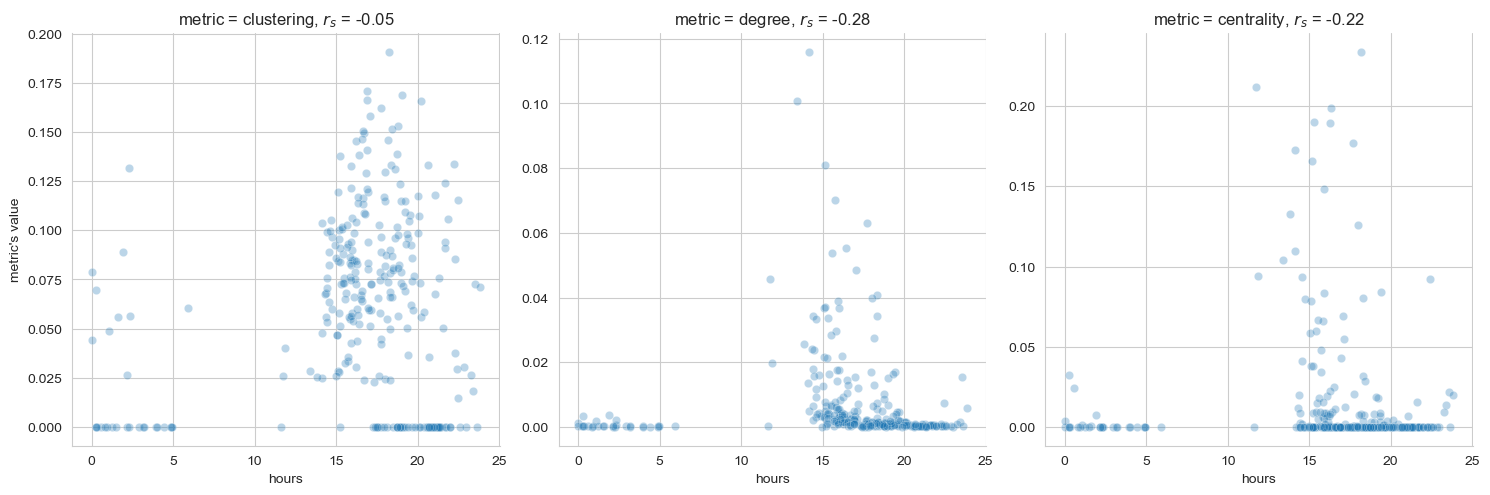

In [46]:
# Рассчитаем часы корреляции Спирмена и показатели
scorr = ap_metrics.drop('dt', axis=1).corr('spearman').loc['hours']
# Создадим df для визуализации
ap_viz = ap_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')
# Визуализациия
sns.set_style('whitegrid')
sp = sns.relplot(data=ap_viz, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.3)
sp.set_ylabels("metric's value")
axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

Clustering rs = -0.05
Centrality rs = −0.22
Degree rs = − 0.28

Degree centrality сильнее всего скоррелирована со временем заражения. Возможно причиной высокой корреляции является то, что чем больше соседей, тем высока вероятность заражения. 